In [11]:
from mylib.statistic_test import *

from mazepy.datastruc.neuact import SpikeTrain, TuningCurve, NeuralTrajectory
from mazepy.datastruc.variables import VariableBin
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

code_id = "0843 - New Map Cross Day Stability"
loc = join(figpath, "Dsp", code_id)
mkdir(loc)

def low_rank_factorization(X, rank_R, k_clusters):
    """
    Performs low-rank matrix factorization with a k-means constraint.

    Parameters:
        X: ndarray (I x J x K) tensor of normalized firing rates
        rank_R: int, rank for the truncated factorization
        k_clusters: int, number of clusters (for k-means constraint)

    Returns:
        U: ndarray, binary clustering assignment (I x R)
        V: ndarray, low-dimensional factors (R x JK)
    """
    # Step 1: Reshape the tensor X into a 2D matrix (I x JK)
    I, J, K = X.shape
    X_reshaped = X.reshape(I, -1)

    # Step 2: Perform truncated SVD for rank-R decomposition
    svd = TruncatedSVD(n_components=rank_R, random_state=42)
    U_continuous = svd.fit_transform(X_reshaped)  # U is continuous
    V = svd.components_  # V shape: (R, JK)

    # Step 3: Apply k-means clustering to enforce binary constraints on U
    kmeans = KMeans(n_clusters=k_clusters, random_state=42)
    U_clusters = kmeans.fit_predict(U_continuous)

    # Reconstruct the matrix using the low-rank representation
    X_reconstructed = np.dot(U_continuous, V)
    
    # Compute the Residual Sum of Squares (RSS)
    cluster_centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    RSS = np.sum([np.linalg.norm(U_continuous[i, :] - cluster_centers[labels[i]]) ** 2 for i in range(U_continuous.shape[0])])  
    
    # Step 4: Calculate per-point distances to their respective cluster centers
    distances = np.linalg.norm(U_continuous - cluster_centers[U_clusters], axis=1).reshape(-1, 1)

    # Step 5: Map cluster assignments to 1 (map1) and -1 (map2)
    U_clusters_binary = np.where(U_clusters == 0, 1, -1)

    # Step 6: Return results
    return distances, V, U_continuous, U_clusters_binary, RSS

def get_lapwise_ratemap(trace: dict):    
    beg_time, end_time = trace['lap beg time'], trace['lap end time']
    beg_idx = np.array([np.where(trace['correct_time'] >= beg_time[i])[0][0] for i in range(beg_time.shape[0])])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg_idx)
    smoothed_map = np.zeros((trace['n_neuron'], 144, beg_idx.shape[0]), dtype = np.float64)
    
    print(np.unique(routes))
    
    for i in tqdm(range(beg_idx.shape[0])):
        
        spike_idx = np.where(
            (trace['ms_time'] >= beg_time[i]) & (trace['ms_time'] <= end_time[i]) &
            (np.isnan(trace['spike_nodes_original']) == False)
        )[0]
        
        spike_nodes = spike_nodes_transform(trace['spike_nodes_original'][spike_idx].astype(np.int64), 12)-1
        Spikes = trace['Spikes_original'][:, spike_idx]
        
        spike_train = SpikeTrain(
            activity=Spikes,
            time=trace['ms_time'][spike_idx],
            variable=VariableBin(spike_nodes),
        )
        
        rate_map = spike_train.calc_tuning_curve(144, t_interv_limits=100)
        smoothed_map[:, :, i] = rate_map.to_array() #@ trace['Ms'].T
    
    return smoothed_map

if exists(join(figdata, code_id+'.pkl')) == False:
    Data = {
        "Map": [],
        "Stability": [],
        "MiceID": [],
        "Training Day": []
    }
    
    for i, mouse in enumerate([10212, 10224, 10227, 10232]):
        with open(f_CellReg_dsp['cellreg_folder'][i+1], 'rb') as handle:
            index_map = pickle.load(handle)
            
            if mouse != 10232:
                index_map = index_map[1:, :]
            
            index_map = index_map.astype(np.int64)
        file_idx = np.where(f2['MiceID'] == mouse)[0]
        
        for j in range(6):
            with open(f2['Trace File'][file_idx[j]], 'rb') as handle:
                trace1 = pickle.load(handle)
            
            with open(f2['Trace File'][file_idx[j+1]], 'rb') as handle:
                trace2 = pickle.load(handle)
        
            routes = [0, 1, 2, 3, 0, 0, 4, 5, 6, 0]
        
            cell_idx = np.where((index_map[j, :] != 0)&(index_map[j+1, :] != 0))[0]
        
            bins = CP_DSP[3]-1
            #bins = np.concatenate([Father2SonGraph[i] for i in CP_DSP[3]])-1
            smoothed_map1 = get_lapwise_ratemap(trace1)[:, bins, :][index_map[j, cell_idx]-1, :, :]
            for d in range(smoothed_map1.shape[0]):
                smoothed_map1[d, :, :] = sklearn.preprocessing.normalize(smoothed_map1[d, :, :], axis=0)

            X1 = smoothed_map1 = np.transpose(smoothed_map1, axes=[2, 1, 0])
        
            smoothed_map2 = get_lapwise_ratemap(trace2)[:, bins, :][index_map[j+1, cell_idx]-1, :, :]
            for d in range(smoothed_map2.shape[0]):
                smoothed_map2[d, :, :] = sklearn.preprocessing.normalize(smoothed_map2[d, :, :], axis=0)

            X2 = smoothed_map2 = np.transpose(smoothed_map2, axes=[2, 1, 0])

            # Example Usage
            # Generate synthetic tensor X (I x J x K)
            #I, J, K = 100, 10, 12  # Example dimensions
            rank_R = 2             # Number of components
            k_clusters = 2         # Number of clusters
        
            # Factorization with constraints
            V1 = low_rank_factorization(X1, rank_R, k_clusters)[1]
            V2 = low_rank_factorization(X2, rank_R, k_clusters)[1]
        
            corr1 = pearsonr(V1[0, :], V2[0, :])[0]
            corr2 = pearsonr(V1[1, :], V2[1, :])[0]
        
            Data['Map'].append(np.array([1, 2]))
            Data['Stability'].append(np.array([corr1, corr2]))
            Data['MiceID'].append(np.array([mouse, mouse]))
            Data['Training Day'].append(np.array([j, j]))
            
            if j == 0:
                corr1 = pearsonr(V1[0, :], V1[1, :])[0]
                corr2 = pearsonr(V2[0, :], V2[1, :])[0]
                Data['Map'].append(np.array([3, 3]))
                Data['Stability'].append(np.array([corr1, corr2]))
                Data['MiceID'].append(np.array([mouse, mouse]))
                Data['Training Day'].append(np.array([j, j+1]))
            else:
                corr2 = pearsonr(V2[0, :], V2[1, :])[0]
                Data['Map'].append(np.array([3]))
                Data['Stability'].append(np.array([corr2]))
                Data['MiceID'].append(np.array([mouse]))
                Data['Training Day'].append(np.array([j+1]))

    for k in Data.keys():
        Data[k] = np.concatenate(Data[k])
        
    with open(join(figdata, code_id+'.pkl'), 'wb') as f:
        pickle.dump(Data, f)
        
    D = pd.DataFrame(Data)
    D.to_excel(join(figdata, code_id+'.xlsx'), index=False)
else:
    with open(join(figdata, code_id+'.pkl'), 'rb') as handle:
        Data = pickle.load(handle)
        

        E:\Data\FinalResults\Dsp\0843 - New Map Cross Day Stability is already existed!


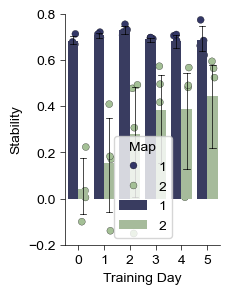

LinregressResult(slope=-0.002575847265520456, intercept=0.7022300938790847, rvalue=-0.13364965761329012, pvalue=0.5335491657007756, stderr=0.004072181470129598, intercept_stderr=0.012329141669987121)
LinregressResult(slope=0.08050082211395376, intercept=0.0803979107274446, rvalue=0.5519470401998243, pvalue=0.005169221648177491, stderr=0.02592953271071087, intercept_stderr=0.07850555889316627)


In [7]:
fig = plt.figure(figsize=(2, 3))

idx = np.where(Data['Map'] != 3)[0]
SubData = SubDict(Data, Data.keys(), idx)
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x='Training Day',
    y='Stability',
    hue='Map',
    data=SubData,
    palette = ['#333766', '#A4C096'], #['#F2E8D4', '#8E9F85', '#C3AED6', '#A7D8DE'],
    ax=ax,
    size = 5,
    linewidth=0.2,
    jitter=0.2,
    dodge=True,
    edgecolor='k',
    zorder=1
)
sns.barplot(
    x='Training Day',
    y='Stability',
    hue='Map',
    data=SubData,
    palette = ['#333766', '#A4C096'],
    ax = ax,
    zorder=2,
    capsize=0.5,
    linewidth=0.5,
    err_kws={"color": 'k', 'linewidth': 0.5}
)
ax.set_ylim(-0.2, 0.8)
plt.savefig(join(loc, "stability.png"), dpi=600)
plt.savefig(join(loc, "stability.svg"), dpi=600)
plt.show()


idxs1 = np.where((SubData['Map'] == 1))[0]
idxs2 = np.where((SubData['Map'] == 2))[0]

print(linregress(SubData['Training Day'][idxs1], SubData['Stability'][idxs1]))
print(linregress(SubData['Training Day'][idxs2], SubData['Stability'][idxs2]))

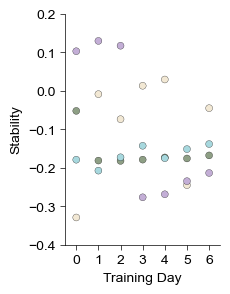

In [16]:
fig = plt.figure(figsize=(2, 3))

idx = np.where(Data['Map'] == 3)[0]
SubData = SubDict(Data, Data.keys(), idx)
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x='Training Day',
    y='Stability',
    hue='MiceID',
    data=SubData,
    palette = ['#F2E8D4', '#8E9F85', '#C3AED6', '#A7D8DE'],
    ax=ax,
    size = 5,
    linewidth=0.2,
    jitter=0.,
    edgecolor='k',
    zorder=1,
    legend=False
)
"""
sns.barplot(
    x='Training Day',
    y='Stability',
    data=SubData,
    ax = ax,
    zorder=2,
    capsize=0.5,
    linewidth=0.5,
    err_kws={"color": 'k', 'linewidth': 0.5}
)
"""
ax.set_ylim(-0.4, 0.2)
plt.savefig(join(loc, "Cross-map correlation.png"), dpi=600)
plt.savefig(join(loc, "Cross-map correlation.svg"), dpi=600)
plt.show()